# Lesson 3: Graph Optimization | Shortest Paths and Minimum Spanning Trees

## Section 1: Introduction to Graph Optimization

Graph optimization deals with finding optimal solutions in graph structures. This lesson explores two fundamental problems:

1. **Single-Source Shortest Path Problem**: Finding the shortest path from a source node to all other nodes (Dijkstra's algorithm)
2. **Minimum Spanning Tree Problem**: Finding a subset of edges that connects all vertices with minimum total weight (Kruskal's algorithm)

**Key differences from previous algorithms:**

- A* finds a single path from start to goal with heuristics
- Dijkstra finds shortest paths from source to **all** nodes without heuristics
- Kruskal builds a tree structure that spans all nodes with minimum cost

**This lesson covers:**
1. Dijkstra's shortest path algorithm
2. Kruskal's minimum spanning tree algorithm with Union-Find
3. Performance analysis and complexity
4. When to use each algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import heapq
from typing import Dict, List, Tuple, Set
from collections import defaultdict

## Section 2: Dijkstra's Shortest Path Algorithm

### Theory

**Dijkstra's algorithm** solves the single-source shortest path problem for graphs with non-negative edge weights.

**Algorithm**: 
1. Initialize distances: source = 0, all others = ∞
2. Use a priority queue to always select the vertex with minimum distance
3. For each neighbor, relax the edge: if new distance < current distance, update it
4. Repeat until all vertices are visited

**Complexity**: 
- Time: $O((V + E) \log V)$ with binary heap
- Space: $O(V)$

**Key Property**: Greedy approach that guarantees optimal shortest paths with non-negative weights.

In [2]:
class WeightedGraph:
    """Weighted graph using adjacency list representation."""
    
    def __init__(self):
        self.graph = defaultdict(list)  # vertex -> [(neighbor, weight), ...]
        self.vertices = set()
    
    def add_edge(self, u, v, weight):
        """Add undirected edge between u and v."""
        self.graph[u].append((v, weight))
        self.graph[v].append((u, weight))
        self.vertices.add(u)
        self.vertices.add(v)
    
    def get_neighbors(self, u):
        """Return list of (neighbor, weight) tuples."""
        return self.graph[u]
    
    def get_vertices(self):
        """Return set of all vertices."""
        return self.vertices

# Create sample graph
graph = WeightedGraph()
edges = [
    ('A', 'B', 4), ('A', 'C', 2), ('B', 'C', 1), ('B', 'D', 5),
    ('C', 'D', 8), ('C', 'E', 10), ('D', 'E', 2), ('D', 'F', 6), ('E', 'F', 3)
]
for u, v, w in edges:
    graph.add_edge(u, v, w)

print("Graph created with vertices:", sorted(graph.get_vertices()))

Graph created with vertices: ['A', 'B', 'C', 'D', 'E', 'F']


### Implementation

In [3]:
def dijkstra(graph: WeightedGraph, source: str) -> Tuple[Dict[str, float], Dict[str, str]]:
    """
    Dijkstra's shortest path algorithm.
    
    Returns:
        distances: shortest distance from source to each vertex
        predecessors: previous vertex in shortest path
    """
    # Initialize
    distances = {v: float('inf') for v in graph.get_vertices()}
    distances[source] = 0
    predecessors = {v: None for v in graph.get_vertices()}
    
    # Priority queue: (distance, vertex)
    pq = [(0, source)]
    visited = set()
    
    while pq:
        current_dist, current = heapq.heappop(pq)
        
        if current in visited:
            continue
        visited.add(current)
        
        # Relaxation: update distances to neighbors
        for neighbor, weight in graph.get_neighbors(current):
            if neighbor in visited:
                continue
            
            new_dist = current_dist + weight
            if new_dist < distances[neighbor]:
                distances[neighbor] = new_dist
                predecessors[neighbor] = current
                heapq.heappush(pq, (new_dist, neighbor))
    
    return distances, predecessors


def reconstruct_path(predecessors: Dict, source: str, target: str) -> List[str]:
    """Reconstruct shortest path from source to target."""
    path = []
    current = target
    while current is not None:
        path.append(current)
        current = predecessors[current]
    path.reverse()
    return path if path[0] == source else []


# Run Dijkstra
print("\n" + "="*50)
print("Dijkstra's Algorithm from source 'A'")
print("="*50)

distances, predecessors = dijkstra(graph, 'A')

print("\nShortest distances:")
for v in sorted(distances.keys()):
    print(f"  A → {v}: {distances[v]:.0f}")

print("\nShortest paths:")
for v in sorted(distances.keys()):
    if v != 'A':
        path = reconstruct_path(predecessors, 'A', v)
        print(f"  {' → '.join(path)} (distance: {distances[v]:.0f})")


Dijkstra's Algorithm from source 'A'

Shortest distances:
  A → A: 0
  A → B: 3
  A → C: 2
  A → D: 8
  A → E: 10
  A → F: 13

Shortest paths:
  A → C → B (distance: 3)
  A → C (distance: 2)
  A → C → B → D (distance: 8)
  A → C → B → D → E (distance: 10)
  A → C → B → D → E → F (distance: 13)


### Visualization

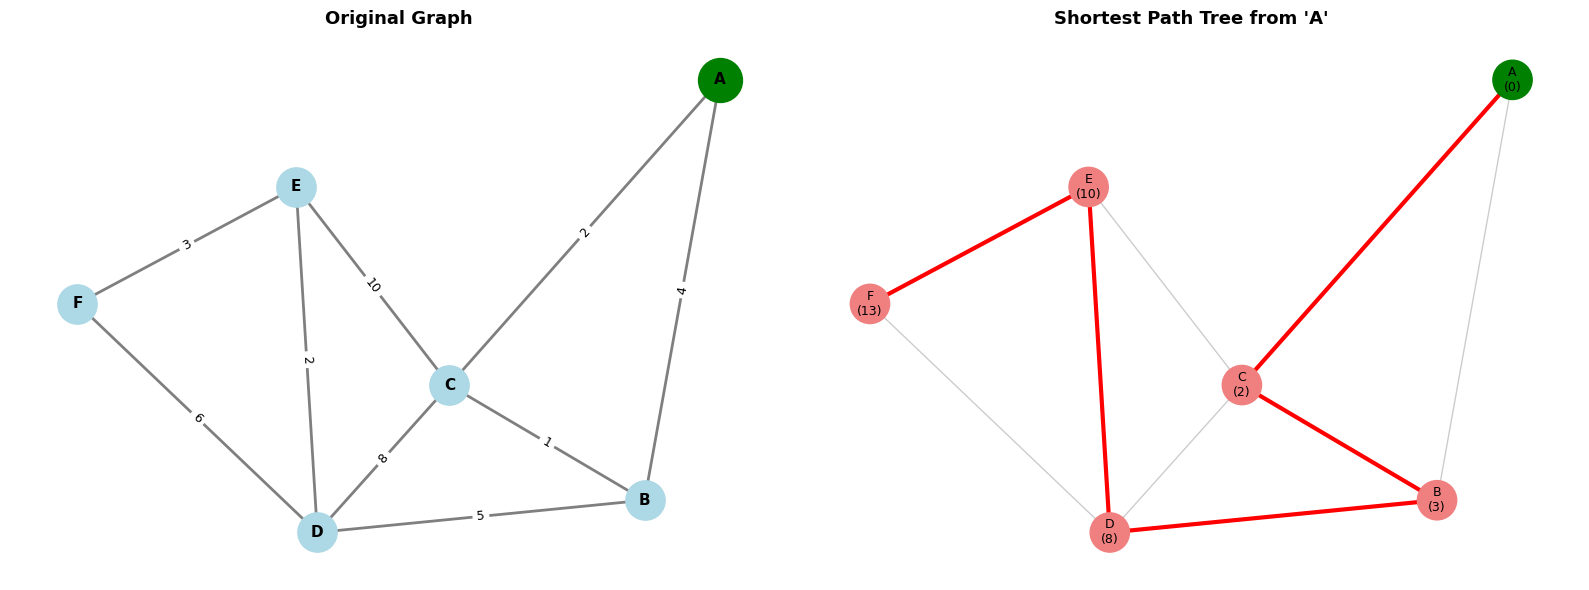

In [4]:
def visualize_dijkstra(graph: WeightedGraph, source: str, distances: Dict, predecessors: Dict):
    """Visualize graph and shortest path tree."""
    G = nx.Graph()
    edge_labels = {}
    
    # Add edges
    for v in graph.get_vertices():
        for neighbor, weight in graph.get_neighbors(v):
            if v < neighbor:
                G.add_edge(v, neighbor, weight=weight)
                edge_labels[(v, neighbor)] = f"{weight}"
    
    pos = nx.spring_layout(G, seed=42, k=2)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original graph
    ax1.set_title("Original Graph", fontsize=13, fontweight='bold')
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, ax=ax1)
    nx.draw_networkx_nodes(G, pos, nodelist=[source], node_color='green', node_size=1000, ax=ax1)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax1)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, ax=ax1)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax1)
    ax1.axis('off')
    
    # Shortest path tree
    ax2.set_title(f"Shortest Path Tree from '{source}'", fontsize=13, fontweight='bold')
    node_colors = ['green' if n == source else 'lightcoral' for n in G.nodes()]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=800, ax=ax2)
    
    # Node labels with distances
    labels = {v: f"{v}\n({distances[v]:.0f})" for v in G.nodes()}
    nx.draw_networkx_labels(G, pos, labels, font_size=9, ax=ax2)
    
    # All edges light, shortest path edges highlighted
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, ax=ax2)
    sp_edges = [(predecessors[v], v) for v in predecessors if predecessors[v] is not None]
    nx.draw_networkx_edges(G, pos, edgelist=sp_edges, width=3, edge_color='red', ax=ax2)
    
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

visualize_dijkstra(graph, 'A', distances, predecessors)

## Section 3: Kruskal's Minimum Spanning Tree Algorithm

### Theory

A **Minimum Spanning Tree (MST)** connects all vertices with minimum total edge weight and no cycles.

**Kruskal's algorithm**:
1. Sort all edges by weight (ascending)
2. Add edges one by one, skipping those that create cycles
3. Stop when all vertices are connected (V-1 edges)

**Complexity**:
- Time: $O(E \log E)$ for sorting
- Space: $O(V + E)$

**Union-Find**: Efficiently detects cycles by tracking which vertices are connected.

### Union-Find Data Structure

In [5]:
class UnionFind:
    """Union-Find with path compression and union by rank."""
    
    def __init__(self, vertices):
        self.parent = {v: v for v in vertices}  # Each vertex is its own parent initially
        self.rank = {v: 0 for v in vertices}    # Tree depth for optimization
    
    def find(self, v):
        """Find root with path compression."""
        if self.parent[v] != v:
            self.parent[v] = self.find(self.parent[v])  # Path compression
        return self.parent[v]
    
    def union(self, v1, v2):
        """Union by rank. Returns True if union performed."""
        root1, root2 = self.find(v1), self.find(v2)
        
        if root1 == root2:
            return False  # Already connected
        
        # Attach smaller tree under larger tree
        if self.rank[root1] < self.rank[root2]:
            self.parent[root1] = root2
        elif self.rank[root1] > self.rank[root2]:
            self.parent[root2] = root1
        else:
            self.parent[root2] = root1
            self.rank[root1] += 1
        return True

# Demo
uf = UnionFind(['A', 'B', 'C', 'D'])
print("Union-Find Demo:")
print(f"Union(A, B): {uf.union('A', 'B')}")
print(f"Union(C, D): {uf.union('C', 'D')}")
print(f"Union(A, C): {uf.union('A', 'C')}")
print(f"Find(B) == Find(D)? {uf.find('B') == uf.find('D')}  (all connected)")

Union-Find Demo:
Union(A, B): True
Union(C, D): True
Union(A, C): True
Find(B) == Find(D)? True  (all connected)


### Implementation

In [7]:
def kruskal(graph: WeightedGraph) -> Tuple[List[Tuple[str, str, float]], float]:
    """
    Kruskal's algorithm for Minimum Spanning Tree.
    
    Returns:
        mst_edges: List of (u, v, weight) in MST
        total_weight: Total MST weight
    """
    # Extract and sort edges
    edges = []
    seen = set()
    for v in graph.get_vertices():
        for neighbor, weight in graph.get_neighbors(v):
            edge = tuple(sorted([v, neighbor]))
            if edge not in seen:
                edges.append((v, neighbor, weight))
                seen.add(edge)
    
    edges.sort(key=lambda x: x[2])  # Sort by weight
    
    # Build MST
    uf = UnionFind(graph.get_vertices())
    mst_edges = []
    total_weight = 0
    
    print("\n" + "="*50)
    print("Kruskal's Algorithm")
    print("="*50)
    print(f"Processing {len(edges)} edges...\n")
    
    for u, v, w in edges:
        if uf.union(u, v):  # No cycle
            mst_edges.append((u, v, w))
            total_weight += w
            print(f"✓ Add edge ({u}, {v}): {w}")
        else:
            print(f"✗ Skip ({u}, {v}): {w} - would create cycle")
        
        if len(mst_edges) == len(graph.get_vertices()) - 1:
            break
    
    print(f"\nMST complete: {len(mst_edges)} edges, total weight: {total_weight}")
    return mst_edges, total_weight

# Run Kruskal
mst_edges, mst_weight = kruskal(graph)


Kruskal's Algorithm
Processing 9 edges...

✓ Add edge (B, C): 1
✓ Add edge (A, C): 2
✓ Add edge (E, D): 2
✓ Add edge (E, F): 3
✗ Skip (A, B): 4 - would create cycle
✓ Add edge (B, D): 5

MST complete: 5 edges, total weight: 13


### Visualization

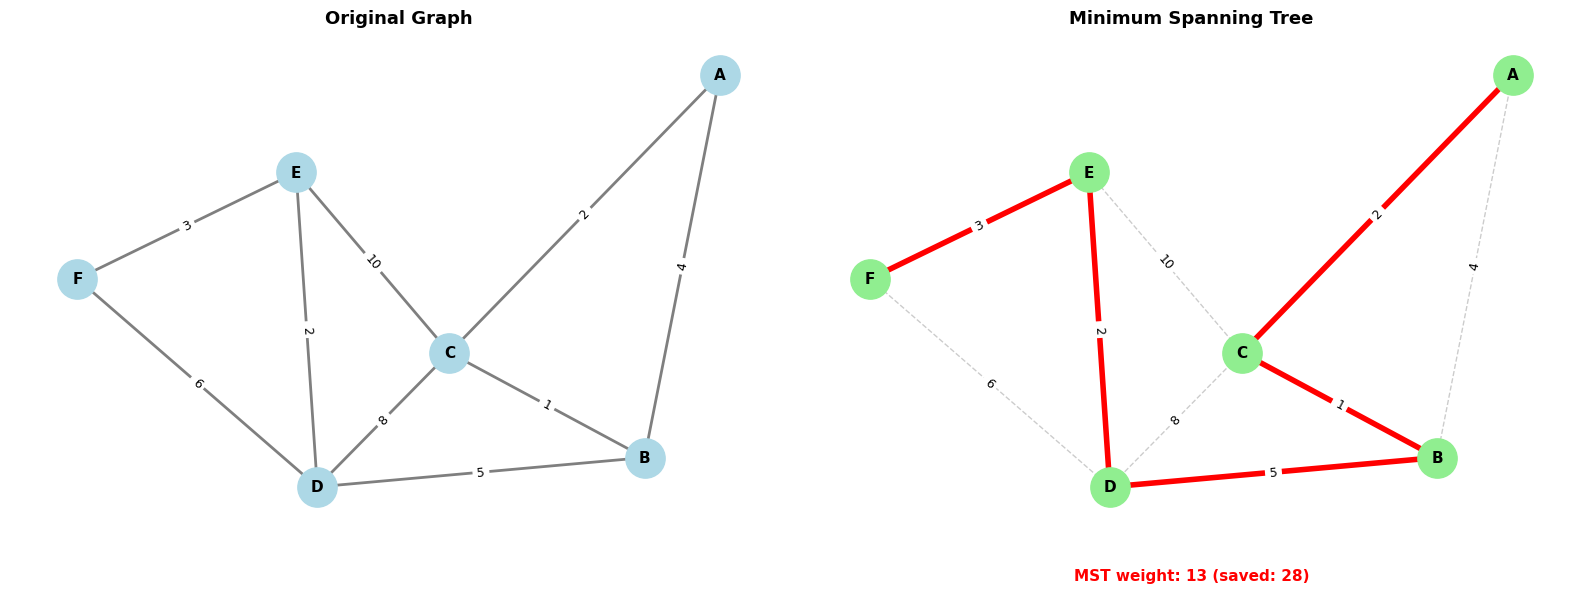

In [8]:
def visualize_mst(graph: WeightedGraph, mst_edges: List[Tuple]):
    """Visualize original graph and MST."""
    G = nx.Graph()
    edge_labels = {}
    
    for v in graph.get_vertices():
        for neighbor, weight in graph.get_neighbors(v):
            if v < neighbor:
                G.add_edge(v, neighbor, weight=weight)
                edge_labels[(v, neighbor)] = f"{weight}"
    
    mst_set = {tuple(sorted([u, v])) for u, v, _ in mst_edges}
    pos = nx.spring_layout(G, seed=42, k=2)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Original graph
    ax1.set_title("Original Graph", fontsize=13, fontweight='bold')
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, ax=ax1)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax1)
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, ax=ax1)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax1)
    ax1.axis('off')
    
    # MST
    ax2.set_title("Minimum Spanning Tree", fontsize=13, fontweight='bold')
    nx.draw_networkx_nodes(G, pos, node_color='lightgreen', node_size=800, ax=ax2)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight='bold', ax=ax2)
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.2, style='dashed', ax=ax2)
    nx.draw_networkx_edges(G, pos, edgelist=list(mst_set), width=4, edge_color='red', ax=ax2)
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=9, ax=ax2)
    
    total_weight = sum(w for _, _, w in [(u, v, d['weight']) for u, v, d in G.edges(data=True)])
    ax2.text(0.5, -0.1, f"MST weight: {mst_weight} (saved: {total_weight - mst_weight})",
             transform=ax2.transAxes, ha='center', fontsize=11, color='red', fontweight='bold')
    
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

visualize_mst(graph, mst_edges)

## Section 4: Algorithm Comparison and Summary

### Complexity Comparison

| Algorithm | Problem | Time Complexity | Space | Key Feature |
|-----------|---------|----------------|-------|-------------|
| **Dijkstra** | Shortest paths | $O((V+E) \log V)$ | $O(V)$ | Finds paths from source to all vertices |
| **Kruskal** | MST | $O(E \log E)$ | $O(V+E)$ | Connects all vertices with min cost |

### When to Use

**Use Dijkstra when:**
- You need shortest paths from a source vertex
- Edge weights are non-negative
- Examples: GPS navigation, network routing

**Use Kruskal when:**
- You need to connect all vertices with minimum total cost
- Building infrastructure networks
- Examples: Network design, cable installation, clustering

### Key Differences

| Aspect | Dijkstra | Kruskal |
|--------|----------|----------|
| **Goal** | Minimize path lengths | Minimize total connection cost |
| **Output** | Distance to each vertex | Set of edges forming tree |
| **Starting Point** | Requires source | No source needed |
| **Approach** | Vertex-based (greedy) | Edge-based (greedy) |
| **Data Structure** | Priority queue | Union-Find + sorting |

### Comparison with Previous Algorithms

| Algorithm | Heuristic | Optimality | Best Use Case |
|-----------|-----------|------------|---------------|
| **BFS** | No | Yes (unweighted) | Unweighted shortest path |
| **DFS** | No | No | Graph traversal |
| **A*** | Yes | Yes (admissible h) | Goal-directed search |
| **Dijkstra** | No | Yes | Weighted shortest paths |
| **Kruskal** | No | Yes | Minimum spanning tree |

### Key Takeaways

1. **Dijkstra** is the go-to algorithm for finding shortest paths in weighted graphs with non-negative weights
2. **Kruskal** efficiently finds the minimum cost to connect all vertices
3. **Union-Find** is crucial for efficient cycle detection in Kruskal's algorithm
4. Both algorithms use **greedy strategies** but solve fundamentally different problems
5. Understanding when to apply each algorithm is essential for solving graph optimization problems

### Practice

To reinforce your understanding:
- Trace both algorithms by hand on small graphs
- Modify the code to work with directed graphs
- Compare performance on graphs of different densities
- Explore related algorithms: Bellman-Ford, Prim's, Floyd-Warshall